## Chemical Descriptors

Comparing the performance of LassoCV (with and without PCA) and RandomForest models :)

In [1]:
# loading all necessary libraries + functions

%matplotlib inline
from matplotlib import pyplot as plt
from rdkit import Chem 
from rdkit.Chem import AllChem 
import pandas as pd
import numpy as np
import gzip
import json

preprocessing!

In [2]:
data_path = '../datasets/qm9.json.gz' # downloading entire QM9 dataset and parsing into a pandas DataFrame
data = pd.read_json(data_path, lines=True)
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)

In [3]:
from mordred import Calculator, descriptors

calc = Calculator(descriptors, ignore_3D=True) # using Mordred to compute features into numpy array
feats = calc.pandas(data['mol'])

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:26<00:00, 93.86it/s]


In [5]:
missing_values = feats.isnull().any() # removing any missing values and converting all data to float
feats = feats.loc[:, ~missing_values].astype(float)

In [6]:
from sklearn.model_selection import train_test_split  # splitting data and features into training and test sets

train_data, test_data, train_feats, test_feats = train_test_split(data, feats, train_size=10000, test_size=2000) # creating distinct training + test datasets

### Training LassoCV models (w/ and w/out PCA)

In [7]:
from sklearn.linear_model import LassoCV # LassoCV model w/out PCA
lasso = LassoCV().fit(train_feats, train_data['bandgap'])

In [9]:
from sklearn.decomposition import PCA # LassoCV model w/ PCA to compress data to 8 features 
pca = PCA().fit(train_feats, test_feats)
pca.n_components = 8
pca_train_feats = pca.fit_transform(train_feats)
pca_test_feats = pca.fit_transform(test_feats)
lasso_pca = LassoCV().fit(pca_train_feats, train_data['bandgap'])

### Training a RandomForest model

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf = rf.fit(train_feats, train_data['bandgap'])

### Plotting Learning Curves (effect of training size on mean absolute error)

##### LassoCV with PCA (better performance than LassoCV w/out PCA)

In [12]:
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error

results = []
    
for s in tqdm([10, 100, 1000]):  # loop over different training set sizes
    for i in range(16):  # repeat the experiment
        subset_data = train_data.sample(s)  # downselect training sets to the desired size
        subset_feats = train_feats.sample(s)
        
        pca = PCA().fit(subset_feats, test_feats) # training LassoCV model with PCA
        pca.n_components = 8
        pca_train_feats = pca.fit_transform(subset_feats)
        pca_test_feats = pca.fit_transform(test_feats)
        lasso_pca = LassoCV().fit(pca_train_feats, subset_data['bandgap'])
        y_pred = lasso_pca.predict(pca_test_feats)

        results.append({
                'train_size': s,
                'iteration': i,
                'r2_score': r2_score(test_data['bandgap'], y_pred),
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # Converts to a dataframe

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e-04, tolerance: 1.842e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-04, tolerance: 1.842e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not conve

In [13]:
results.to_csv('test.csv')

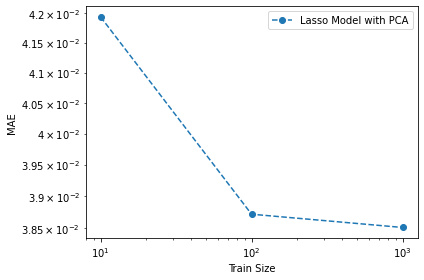

In [14]:
fig, ax = plt.subplots()

group_stats = results.groupby('train_size').mean()
ax.loglog(group_stats.index, group_stats['mae'], '--o', label=f'Lasso Model with PCA') 
ax.legend()

ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
fig.tight_layout()

##### LassoCV without PCA

In [16]:
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error

results = []

for s in tqdm([10, 100, 1000]):  # Loop over different training set sizes
    for i in range(16):  # Repeat the experiment
        subset_data = train_data.sample(s)  # Downselect to the desired size
        subset_feats = train_feats.sample(s)
        
            # Train and test the model
        lasso = lasso.fit(subset_feats, subset_data['bandgap'])
        y_pred = lasso.predict(test_feats)

        results.append({
                'train_size': s,
                'iteration': i,
                'r2_score': r2_score(test_data['bandgap'], y_pred),
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # Converts to a dataframe

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e-06, tolerance: 1.967e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-05, tolerance: 1.967e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not conve

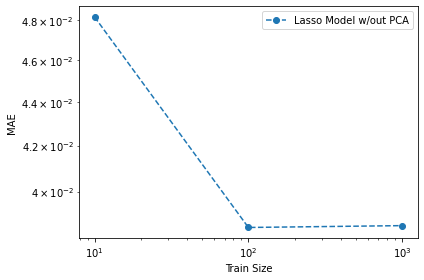

In [17]:
results.to_csv('test.csv')
fig, ax = plt.subplots()

group_stats = results.groupby('train_size').mean()
ax.loglog(group_stats.index, group_stats['mae'], '--o', label=f'Lasso Model w/out PCA') 
ax.legend()

ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
fig.tight_layout()

##### RandomForest 

In [18]:
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error

results = []

for s in tqdm([10, 100, 1000]):  # Loop over different training set sizes
    for i in range(16):  # Repeat the experiment
        subset_data = train_data.sample(s)  # Downselect to the desired size
        subset_feats = train_feats.sample(s)
        
            # Train and test the model
        rf = rf.fit(subset_feats, subset_data['bandgap'])
        y_pred = rf.predict(test_feats)

        results.append({
                'train_size': s,
                'iteration': i,
                'r2_score': r2_score(test_data['bandgap'], y_pred),
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # Converts to a dataframe

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:24<00:00, 168.11s/it]


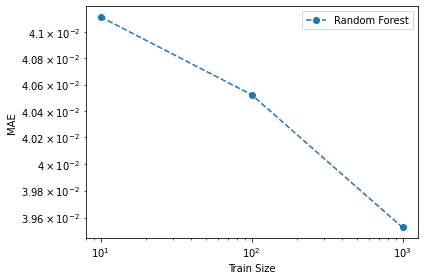

In [19]:
results.to_csv('test.csv')
fig, ax = plt.subplots()

group_stats = results.groupby('train_size').mean()
ax.loglog(group_stats.index, group_stats['mae'], '--o', label=f'Random Forest') 
ax.legend()

ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
fig.tight_layout()

### Ranking Top Features for LASSOCV and Random Forest

In [20]:
importance_rf = np.argsort(rf.feature_importances_)
importance_rf

array([626, 930, 929, ..., 169, 167, 327], dtype=int64)

In [37]:
importance_lasso = np.argsort(lasso.coef_)
print(importance_lasso)

[   0  702  703 ...  357 1066  120]


In [22]:
set_rf = set(importance_rf[:10])
set_lasso = set(importance_lasso[:10])

In [23]:
top_set = set_rf.union(set_lasso)
top_set # DIFFERENT top features for LassoCV + Random forest because measuring TWO DIFFERENT THINGS (lasso models correlation with data, Random Forest measures improvement in accuracy)

{0,
 560,
 626,
 683,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 918,
 919,
 926,
 927,
 928,
 929,
 930}

### Calculating correlation between top ten features in each model

##### LassoCV without PCA

In [26]:
cross_corr_lasso = np.corrcoef(feats.loc[importance_lasso][:10])
print(cross_corr_lasso)

[[1.         0.97064787 0.90912775 0.95316473 0.92132692 0.94981303
  0.93907574 0.90828917 0.96380008 0.97452875]
 [0.97064787 1.         0.90944363 0.99546529 0.91926451 0.95500143
  0.97206697 0.90140758 0.97383771 0.96629466]
 [0.90912775 0.90944363 1.         0.90066636 0.99681834 0.96505027
  0.93969938 0.98303862 0.97342735 0.96515096]
 [0.95316473 0.99546529 0.90066636 1.         0.90656918 0.94644354
  0.96959793 0.89563161 0.96662937 0.95216913]
 [0.92132692 0.91926451 0.99681834 0.90656918 1.         0.97480035
  0.94832619 0.98111316 0.97861537 0.97112274]
 [0.94981303 0.95500143 0.96505027 0.94644354 0.97480035 1.
  0.97406902 0.96004507 0.98924716 0.97486031]
 [0.93907574 0.97206697 0.93969938 0.96959793 0.94832619 0.97406902
  1.         0.94265553 0.97654918 0.94721301]
 [0.90828917 0.90140758 0.98303862 0.89563161 0.98111316 0.96004507
  0.94265553 1.         0.96634765 0.94110235]
 [0.96380008 0.97383771 0.97342735 0.96662937 0.97861537 0.98924716
  0.97654918 0.96634

##### RandomForest

In [28]:
cross_corr_rf = np.corrcoef(feats.loc[importance_rf][:10])
print(cross_corr_rf)

[[1.         0.90102893 0.99593236 0.96848319 0.97171562 0.91543259
  0.97572102 0.98129604 0.79910222 0.94211369]
 [0.90102893 1.         0.91319498 0.86824084 0.92188594 0.98242465
  0.94836433 0.91388711 0.95341112 0.86663584]
 [0.99593236 0.91319498 1.         0.94918925 0.96039862 0.92702805
  0.9724596  0.97232112 0.80870764 0.9354902 ]
 [0.96848319 0.86824084 0.94918925 1.         0.98705888 0.88124943
  0.96785065 0.98864145 0.80637301 0.96845451]
 [0.97171562 0.92188594 0.96039862 0.98705888 1.         0.93324868
  0.98944197 0.99131597 0.8690349  0.96528314]
 [0.91543259 0.98242465 0.92702805 0.88124943 0.93324868 1.
  0.95525867 0.91482298 0.95262115 0.88139937]
 [0.97572102 0.94836433 0.9724596  0.96785065 0.98944197 0.95525867
  1.         0.98789332 0.88399725 0.95646167]
 [0.98129604 0.91388711 0.97232112 0.98864145 0.99131597 0.91482298
  0.98789332 1.         0.83923863 0.97156323]
 [0.79910222 0.95341112 0.80870764 0.80637301 0.8690349  0.95262115
  0.88399725 0.83923

### Refitting Lasso Model with new 1000 data points

In [34]:
subset_data = train_data.sample(1000) 
subset_feats = train_feats.sample(1000)
lasso_new = lasso.fit(subset_feats, subset_data['bandgap'])

C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e-04, tolerance: 1.821e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e-04, tolerance: 1.821e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\joseph.LAPTOP-I04K7UA9\joseph\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [38]:
importance_lasso_new = np.argsort(lasso_new.coef_)
print(importance_lasso_new)

[   0  702  703 ...  357 1066  120]


In [36]:
cross_corr_lasso_new = np.corrcoef(feats.loc[importance_lasso_new][:10])
print(cross_corr_lasso_new) 

[[1.         0.97064787 0.90912775 0.95316473 0.92132692 0.94981303
  0.93907574 0.90828917 0.96380008 0.97452875]
 [0.97064787 1.         0.90944363 0.99546529 0.91926451 0.95500143
  0.97206697 0.90140758 0.97383771 0.96629466]
 [0.90912775 0.90944363 1.         0.90066636 0.99681834 0.96505027
  0.93969938 0.98303862 0.97342735 0.96515096]
 [0.95316473 0.99546529 0.90066636 1.         0.90656918 0.94644354
  0.96959793 0.89563161 0.96662937 0.95216913]
 [0.92132692 0.91926451 0.99681834 0.90656918 1.         0.97480035
  0.94832619 0.98111316 0.97861537 0.97112274]
 [0.94981303 0.95500143 0.96505027 0.94644354 0.97480035 1.
  0.97406902 0.96004507 0.98924716 0.97486031]
 [0.93907574 0.97206697 0.93969938 0.96959793 0.94832619 0.97406902
  1.         0.94265553 0.97654918 0.94721301]
 [0.90828917 0.90140758 0.98303862 0.89563161 0.98111316 0.96004507
  0.94265553 1.         0.96634765 0.94110235]
 [0.96380008 0.97383771 0.97342735 0.96662937 0.97861537 0.98924716
  0.97654918 0.96634